<a href="https://colab.research.google.com/github/rohitnikam1/Time_Series_Forecasting/blob/master/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting

**Data**
 - A publicly available information about Berlin city's Airbnb's listings, which is a summary review data and listing ID (to facilitate time based analytics and visualisations linked to a listing) (http://insideairbnb.com/get-the-data.html)

**Task**
 - Forecasting of future listings for the year of 2021.

**Tools used**
 - Statistical models
   - Univariate time-series modelling: Transformation, decomposition
   - ARIMA model
   - Additive or component based models (Facebook Prophet package)
 - Machine Learning models
   - Recurrent Neural Networks (RNNs): Long Short-Term Memory Networks (LSTMs)

# Import relevant packages

Ideally, one should set up their own virtual environment and determine the versions of each library that they are using. Here, we will assume that the colaboratory environment has some shared environment with access to common python libraries and the ability to install other required libraries.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from IPython.display import display, HTML, display_html
import datetime
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

# Set formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab_Notebooks/Time_Series_Forcasting/data/reviews.csv'

## Read data

In [ ]:
df = pd.read_csv(path)

## Looking at data

In [ ]:
# look at the data
display(df.head())

# look at the shape of the data
display(df.shape)

# look at the datatypes
display(df.dtypes)

# see if any columns have nulls
display(df.isnull().any())

# display descriptive statistics
display(df.describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.95, 0.99]))

,listing_id,date
0,2015,2016-04-11
1,2015,2016-04-15
2,2015,2016-04-26
3,2015,2016-05-10
4,2015,2016-05-14


(416766, 2)

listing_id     int64
date          object
dtype: object

listing_id    False
date          False
dtype: bool

,listing_id
count,4.167660e+05
mean,1.582541e+07
std,1.278406e+07
min,2.015000e+03
25%,4.027713e+06
50%,1.409896e+07
75%,2.432991e+07
85%,3.037347e+07
95%,3.994176e+07
99%,4.886878e+07


## **What are some questions that can be answered with this data?**
- Understand the limitations of your data. It is important to know what potential questions can be answered by the data. These questions can reduce, expand or modify the scope of the project.<d>
- If the scope or goal for the project is defined before digging into the data, this is a good time to revisit it.

- **Questions that can be answered**
 - Forcast future number of reviews for the Berlin area.
 - Forcast the future number of reviews for specific listings in the Berlin Area.

## **What techniques may help answer these questions?**
### **Statistical Models**
- **Ignore the time-series aspect completely and model using traditional statistical modelling toolbox** (not the best idea, since the inherent time-series order and structure is not leveraged)
 - Ex.: Regression based models
- **Univariate statistical time-series modelling**
  - Ex.: Averaging and smoothing models, ARIMA models
- **Slight modifications to univariate statistical time-series modelling**
 - Ex.: External regressors, multivariate models
- **Additive or component models**
 - Ex.: Facebook Prophet package (good for quick estimate of forecast)
- **Structural time-series modelling**
 - Ex.: Bayesian structural time-series modelling, hierarchical time-series modelling

### **Machine learning models**
- **Ignore the time-series aspect completely and model using traditional machine learning modelling toolbox**
 - Ex.: Support Vector Machines (SVMs), Random Forest Regression, Gradient-boosted Decision Trees (GBDTs)
- **Hidden Markov models (HMMs)**
- **Other sequence based models**
- **Gaussian processes**
- **Recurrent neural networks (RNNs)**

### **Additional data considerations before choosing a model**
- Whether or not to incorporat external data**
- Whether or not to keep as univariate or multivariate (i.e. which features and number of features)
- Outlier detection and removal
- Missing value imputation

## **Let's analyse some time-series data!**
### **Process the data**

In [ ]:
# Rename columns
df = df.rename(columns={'date': 'ds', 'listing_id': 'ts'})
display(df.head())

# Change index to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Set index as date
df.set_index('ds', inplace=True)

# Group data by number of listings per date
df_example = df.groupby(by = 'ds').agg({'ts': 'count'})

# Set frequency of time-series
df_example = df_example.asfreq(freq = '1D')

# Sort the values
df_example =  df_example.sort_index(ascending = True)

# Fill NaN values with zero
df_example = df_example.fillna(value = 0)

# Show the end of the data
display(df_example.tail())

,ts,ds
0,2015,2016-04-11
1,2015,2016-04-15
2,2015,2016-04-26
3,2015,2016-05-10
4,2015,2016-05-14


,ts
ds,
2021-09-25,0.0
2021-09-26,1.0
2021-09-27,1.0
2021-09-28,1.0
2021-09-29,1.0


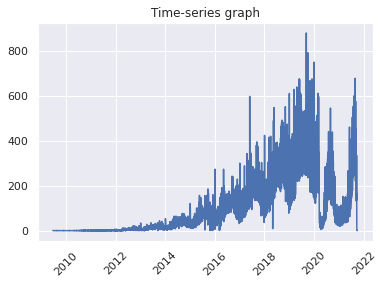

In [ ]:
# Plot time-series data
f, ax = plt.subplots(1,1)
ax.plot(df_example['ts'])

# Add title
ax.set_title('Time-series graph')

# Rotate x-labels
ax.tick_params(axis = 'x', rotation = 45)

plt.show()
plt.close()

- There does seem to be an overall increasing trend. There is a big dip around year 2021, possibly indicating the decline in short term rentals due to COVID-19.
- Variance seems to be changing over time
- There may be some seasonality in the data.
- Not sure about outliers.

## **Look at Stationarity**
Most time-series models assume that the underlying time-series data is **stationary**. This assumption gives us some nice statistical properties that allows us to use various forecasting models.

**Stationarity** is a statistical assumption that a time-series has
 - **Constant mean**
 - **Constant variance**
 - **Autocovariance is time independent**
More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends as in the past. This general statement hold true for most training data and modelling tasks.

Sometimes we need to transform the data to make it stationary. However, this transformation then calls into question if the data is truly stationary and is suited to be modelled using these techniques.


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
  '''
  Test stationarity using moving average statistics and Dickey-Fuller test
  Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
  '''

  # Determine rolling statistics
  rollmean = df[ts].rolling(window=12, center = False).mean()
  rollstd  = df[ts].rolling(window=12, center = False).std()

  # Plot rolling statistics
  orig = plt.plot(df[ts], color='blue', label = 'Original')
  mean = plt.plot(rollmean, color='red', label = 'Rolling mean')
  std = plt.plot(rollstd, color='black', label = 'Rolling std')
  plt.legend(loc = 'best')
  plt.title(f'Rolling Mean and Standard Deviation for {ts}')
  plt.xticks(rotation = 45)
  plt.show(block = False)
  plt.close()

  # Perform Dickey-Fuller Test
  # Null Hypothesis      (H_0): Time-series is NOT stationary.
  # Alternate Hypothesis (H_1): Time-series IS stationary.
  print('Results of Dickey-Fuller Test')
  dftest = adfuller(df[ts], autolag = 'AIC')
  dfoutput = pd.Series(dftest[:4], index = ['Test Statistic', 'p-value', '# Lags used', '# Observations used'])
  for key, value in dftest[4].items():
    dfoutput[f'Critical Value {key}'] = value
  print(dfoutput)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


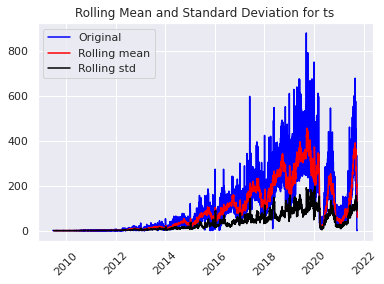

Results of Dickey-Fuller Test
Test Statistic           -2.633356
p-value                   0.086297
# Lags used              28.000000
# Observations used    4456.000000
Critical Value 1%        -3.431818
Critical Value 5%        -2.862189
Critical Value 10%       -2.567115
dtype: float64


In [ ]:
test_stationarity(df = df_example, ts = 'ts')

Rolling mean and standard deviation look like they change over time. There may be some de-trending and removing seasonality involved. Based in **Dickey-Fuller Test**, because $p=0.08$, we fail to reject the null hypothesis (that the time-series data is not stationary) at the $p=0.05$ level, thus concluding that we fail to reject the null hypothesis that our **time-series data is not stationary**.

## **Corrections for Stationarity**
It is common for the time-series to have to be corrected for stationarity.
Two common reasons behind non-stationarity are:
 1. **Trend**: mean is not constant over time
 2. **Seasonality**: variance is not constant over time

 There are ways to correct for trend and seasonality, to make the time-series stationary.

 **What happens if you do not correct for these things?**
 Many things can happen, including:
  - Variance can be mis-specified
  - Model fit can be worse
  - Not leveragin valuable time-dependent nature of the data.


## **Eliminating Trend and Seasonality**
 - **Transformation**
  - Ex.: Log, Square-root, etc.
 - **Soothing**
  - Ex.: Weekly average, monthly average, rolling averages
 - **Differencing**
  - Ex.: First-order differencing
 - **Polynomial Fitting**
  - Ex.: Fit a regression model
 - **Decomposition**

## **Transformation, Smoothing and Differencing**

In [ ]:
def plot_transformed_data(df, ts, ts_transform):
  '''
  Plot transformed and original time-series data
  '''
  # Plot time-series data
  f, ax = plt.subplots(1,1)
  ax.plot(df[ts])
  ax.plot(df[ts_transform], color = 'red')

  # Add title
  ax.set_title(f'{ts} and {ts_transform} time-series graph')

  # Rotate x-labels
  ax.tick_params(axis ='x', rotation = 45)

  # Add legend
  ax.legend([ts, ts_transform])

  plt.show()
  plt.close()

  return

/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
ds,,,,,,,,,
2011-11-13,1.0,0.000000,0.610952,2.000000,0.000000,-1.000000,-0.610952,0.000000,0.000000
2011-11-14,4.0,1.386294,0.652050,2.142857,1.386294,1.857143,0.734245,0.727437,0.658857
2011-11-15,1.0,0.000000,0.553029,2.000000,-1.386294,-1.000000,-0.553029,0.460591,-0.460591
2012-02-15,1.0,0.000000,0.354987,1.571429,-0.693147,-0.571429,-0.354987,0.327820,-0.327820
2012-02-16,1.0,0.000000,0.354987,1.571429,0.000000,-0.571429,-0.354987,0.248675,-0.248675


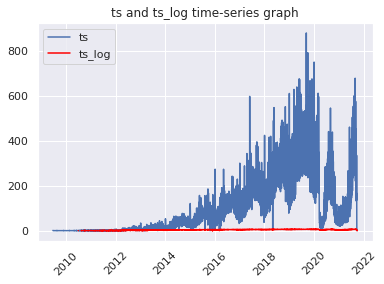

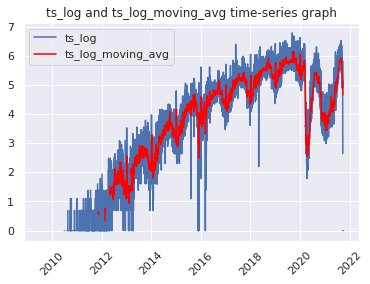

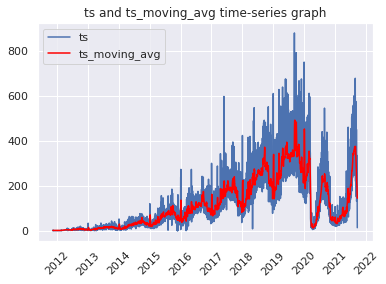

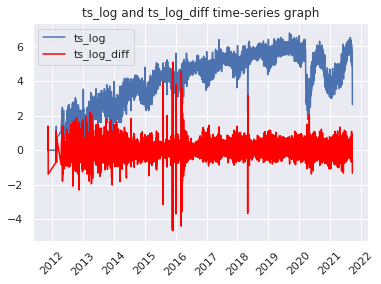

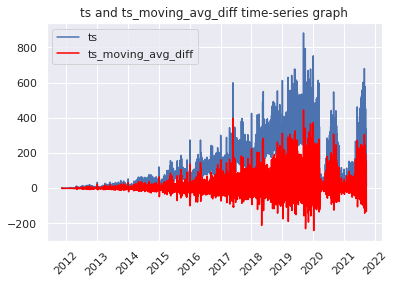

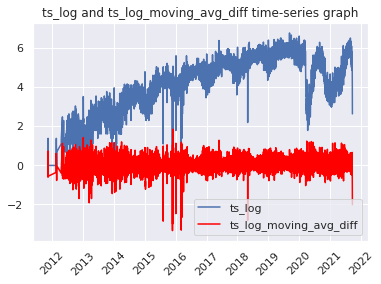

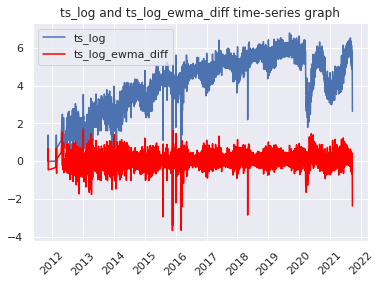

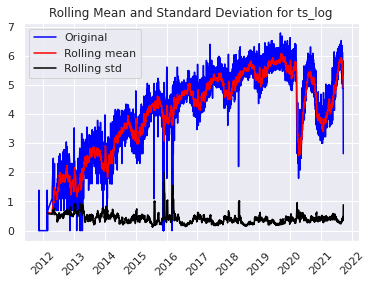

Results of Dickey-Fuller Test
Test Statistic           -2.449405
p-value                   0.128275
# Lags used              29.000000
# Observations used    3315.000000
Critical Value 1%        -3.432324
Critical Value 5%        -2.862412
Critical Value 10%       -2.567234
dtype: float64


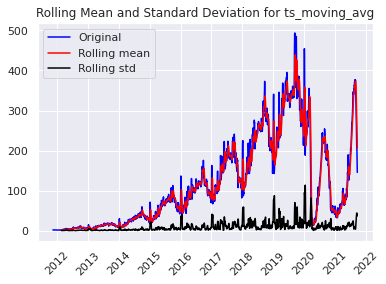

Results of Dickey-Fuller Test
Test Statistic           -2.408606
p-value                   0.139322
# Lags used              29.000000
# Observations used    3315.000000
Critical Value 1%        -3.432324
Critical Value 5%        -2.862412
Critical Value 10%       -2.567234
dtype: float64


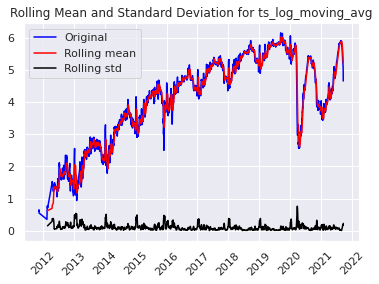

Results of Dickey-Fuller Test
Test Statistic           -2.441578
p-value                   0.130343
# Lags used              29.000000
# Observations used    3315.000000
Critical Value 1%        -3.432324
Critical Value 5%        -2.862412
Critical Value 10%       -2.567234
dtype: float64


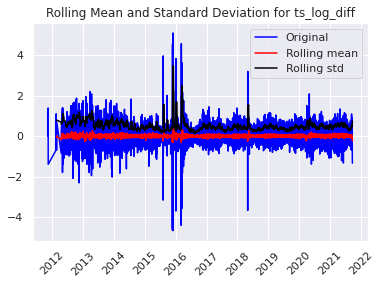

Results of Dickey-Fuller Test
Test Statistic        -1.384242e+01
p-value                7.251500e-26
# Lags used            2.600000e+01
# Observations used    3.318000e+03
Critical Value 1%     -3.432322e+00
Critical Value 5%     -2.862411e+00
Critical Value 10%    -2.567234e+00
dtype: float64


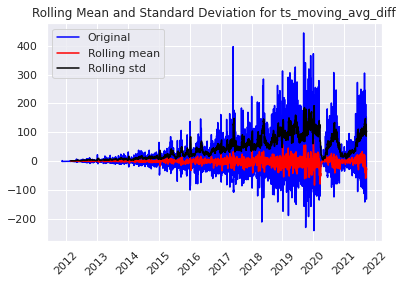

Results of Dickey-Fuller Test
Test Statistic        -1.184691e+01
p-value                7.362640e-22
# Lags used            2.800000e+01
# Observations used    3.316000e+03
Critical Value 1%     -3.432324e+00
Critical Value 5%     -2.862412e+00
Critical Value 10%    -2.567234e+00
dtype: float64


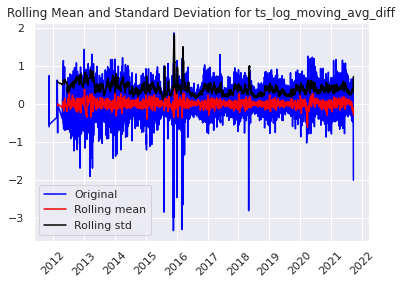

Results of Dickey-Fuller Test
Test Statistic        -1.078503e+01
p-value                2.205386e-19
# Lags used            2.900000e+01
# Observations used    3.315000e+03
Critical Value 1%     -3.432324e+00
Critical Value 5%     -2.862412e+00
Critical Value 10%    -2.567234e+00
dtype: float64


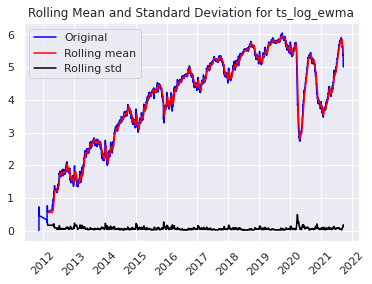

Results of Dickey-Fuller Test
Test Statistic           -2.536813
p-value                   0.106772
# Lags used              28.000000
# Observations used    3316.000000
Critical Value 1%        -3.432324
Critical Value 5%        -2.862412
Critical Value 10%       -2.567234
dtype: float64


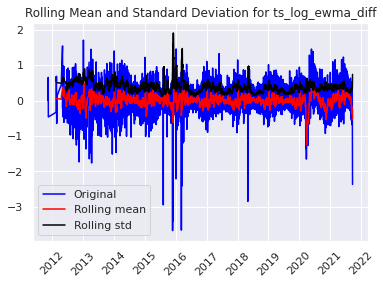

Results of Dickey-Fuller Test
Test Statistic        -8.056740e+00
p-value                1.684631e-12
# Lags used            2.700000e+01
# Observations used    3.317000e+03
Critical Value 1%     -3.432323e+00
Critical Value 5%     -2.862412e+00
Critical Value 10%    -2.567234e+00
dtype: float64


In [ ]:
# Transformation - log ts
df_example['ts_log'] = df_example['ts'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
df_example['ts_log_moving_avg'] = df_example['ts_log'].rolling(window = 7, center = False).mean()

# Transformation - 7-day moving averages of ts
df_example['ts_moving_avg'] = df_example['ts'].rolling(window = 7, center = False).mean()

# Transformation - Difference between log ts and first-order difference log ts
df_example['ts_log_diff'] = df_example['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
df_example['ts_moving_avg_diff'] = df_example['ts'] - df_example['ts_moving_avg']

# Transformation - Difference between log ts and log moving average ts
df_example['ts_log_moving_avg_diff'] = df_example['ts_log'] - df_example['ts_log_moving_avg']

# Remove Nulls from data
df_example_transform = df_example.dropna()

# Transformation - log exponentially weighted moving averages (EWMA) ts
df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7, 
                                                                         ignore_na = False, 
                                                                         min_periods = 0, 
                                                                         adjust = True).mean()

# Transformation - Difference between log ts and log EWMA ts
df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts_log'] - df_example_transform['ts_log_ewma']

# Display data
display(df_example_transform.head())

# Plot data
plot_transformed_data(df = df_example,
                      ts = 'ts',
                      ts_transform = 'ts_log')

plot_transformed_data(df = df_example,
                      ts = 'ts_log',
                      ts_transform = 'ts_log_moving_avg')

plot_transformed_data(df = df_example_transform,
                      ts = 'ts',
                      ts_transform = 'ts_moving_avg')

plot_transformed_data(df = df_example_transform,
                      ts = 'ts_log',
                      ts_transform = 'ts_log_diff')

plot_transformed_data(df = df_example_transform,
                      ts = 'ts',
                      ts_transform = 'ts_moving_avg_diff')

plot_transformed_data(df = df_example_transform,
                      ts = 'ts_log',
                      ts_transform = 'ts_log_moving_avg_diff')

plot_transformed_data(df = df_example_transform,
                      ts = 'ts_log',
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity tests
test_stationarity(df = df_example_transform, ts = 'ts_log')
test_stationarity(df = df_example_transform, ts = 'ts_moving_avg')
test_stationarity(df = df_example_transform, ts = 'ts_log_moving_avg')
test_stationarity(df = df_example_transform, ts = 'ts_log_diff')
test_stationarity(df = df_example_transform, ts = 'ts_moving_avg_diff')
test_stationarity(df = df_example_transform, ts = 'ts_log_moving_avg_diff')
test_stationarity(df = df_example_transform, ts = 'ts_log_ewma')
test_stationarity(df = df_example_transform, ts = 'ts_log_ewma_diff')

Applying log transformation, weekly moving average smoothing, and differencing made the data more stationary over time. Based on **Dickey-Fuller test**, because $p \le 0.05$, we are able to reject the null hypothesis (that the time series is not stationary) at $p = 0.05$ level, thereby concluding that **the time-series is stationary**.

## **Decomposition: Trend, Seasonality, Residuals**

In [ ]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  '''
  Plot time-series data
  '''
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 5), sharex=True)

  ax1.plot(df[ts], label='Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(trend, label='Trend', color='red')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(seasonal, label='Seasonality', color = 'black')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(residual, label='Residual', color = 'green')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  plt.suptitle(f'Trend, Seasonal and Residual Decomposition of {ts}',
               x = 0.5,
               y = 1.05,
               fontsize = 18)
  plt.show()
  plt.close()

  return

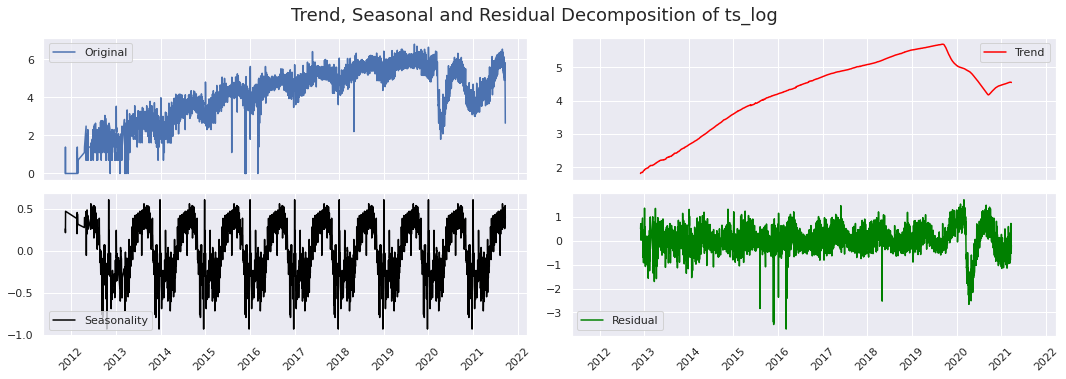

Results of Dickey-Fuller Test on the Residual
Test Statistic           -5.392774
p-value                   0.000004
# Lags used              29.000000
# Observations used    2951.000000
Critical Value 1%        -3.432568
Critical Value 5%        -2.862520
Critical Value 10%       -2.567292
dtype: float64


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_example_transform['ts_log'], freq = 365)
# df_decom = pd.DataFrame({'ts_log': df_example_transform['ts_log'], 
#                          'trend': decomposition.trend, 
#                          'seasonal': decomposition.seasonal, 
#                          'resid': decomposition.resid})

plot_decomposition(df = df_example_transform, 
                   ts = 'ts_log', 
                   trend = decomposition.trend, 
                   seasonal = decomposition.seasonal, 
                   residual = decomposition.resid)

# Remove Nulls from Residual
residual = decomposition.resid.dropna()

# Perform Dickey-Fuller Test on Residual
# Null Hypothesis      (H_0): Time-series is NOT stationary.
# Alternate Hypothesis (H_1): Time-series IS stationary.
print('Results of Dickey-Fuller Test on the Residual')
dftest = adfuller(residual, autolag = 'AIC')
dfoutput = pd.Series(dftest[:4], index = ['Test Statistic', 'p-value', '# Lags used', '# Observations used'])
for key, value in dftest[4].items():
  dfoutput[f'Critical Value {key}'] = value
print(dfoutput)

De-trending and de-seasonalizing made the data (i.e., the residuals) more stationary over time. Based on **Dickey-Fuller test**, because $p \le 0.05$, we are able to reject the null hypothesis (that the time series is not stationary) at $p = 0.05$ level, thereby concluding that **the residual time-series is stationary**.

# **Modelling Time-Series Data: ARIMA Models**
We can use ARIMA models when we know that there is a dependence between values and we can leverage that information to forecast.

**ARIMA: Auto-Regressive Integrated Moving Average**
**Assumptions:** The time-series is stationary.
**Depends on:**
 1. **Number of AR (Auto-Regressive) terms ($p$)**
 2. **Number of I (Integrated or Difference) terms ($d$)**
 3. **Number of MA (Moving Average) terms ($q$)**


## **Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) Plots**

**How do we determine $p$, $d$ and $q$ ?** For $p$ and $q$ we can use ACF and PACF plots (below)
**Autocorrelation Function (ACF):** Correlation between the time series with a lagged version of itself (e.g. correlation of $Y(t)$ with $Y(t-1)$)

**Partial Autocorrelation Function (PACF):** Additional correlation contributed by each successive lagged term .

**How do we interprete ACF and PACF plots?**
 - $p:$ Lag value where the PACF chart crosses the upper confidence interval for the first time
 - $q:$ Lag value where the ACF chart crosses the upper confidence interval for the first time 

In [ ]:
def plot_acf_pacf(df, ts, nlags = 20):
  '''
  Plot auto-correlation function (ACF) and partial auto-correlation function (PACF) 
  '''
  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

  # Plot ACF

  ax1.plot(acf(df[ts], fft = True, nlags = nlags))
  ax1.axhline(y = 0, linestyle = '--', color = 'gray')
  ax1.axhline(y =-1.96/np.sqrt(len(df[ts])), linestyle = '--', color = 'gray')
  ax1.axhline(y = 1.96/np.sqrt(len(df[ts])), linestyle = '--', color = 'gray')
  ax1.set_title(f'Auto-Correlation Function for {ts}')

  # Plot PACF

  ax2.plot(pacf(df[ts], nlags = nlags))
  ax2.axhline(y = 0, linestyle = '--', color = 'gray')
  ax2.axhline(y =-1.96/np.sqrt(len(df[ts])), linestyle = '--', color = 'gray')
  ax2.axhline(y = 1.96/np.sqrt(len(df[ts])), linestyle = '--', color = 'gray')
  ax2.set_title(f'Partial Auto-Correlation Function for {ts}')

  plt.tight_layout()
  plt.show()
  plt.close()

  return

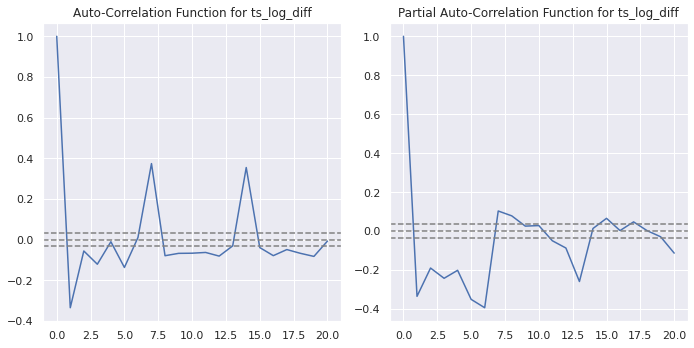

In [ ]:
# ACF for PACF plots

from statsmodels.tsa.stattools import acf, pacf
plot_acf_pacf(df = df_example_transform, ts = 'ts_log_diff')

In [ ]:
def run_arima_model(df, ts, p, d, q):
  '''
  Run ARIMA model
  '''
  from statsmodels.tsa.arima_model import ARIMA

  # Fit ARIMA model on time-series
  model = ARIMA(df[ts], order = (p, d, q))
  results_ = model.fit(disp = -1)

  # Get lengths correct to calculate Residual Sum of Squares (RSS)
  len_results = len(results_.fittedvalues)
  ts_modified = df[ts][-len_results:]

  # Calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[ts]))

  # plot fit
  plt.plot(df[ts])
  plt.plot(results_.fittedvalues, color = 'red')
  plt.title(f'For ARIMA model {p}, {d}, {q} for {ts}, RSS:{rss:.4f}, RMSE:{rmse:.4f}')

  plt.show()
  plt.close()

  return results_

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


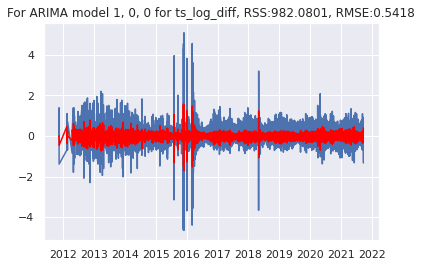

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


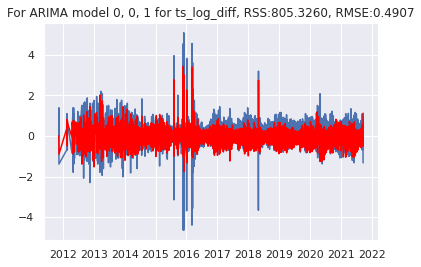

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


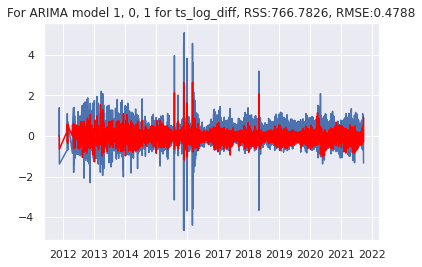

In [ ]:
# Note: The differencing is carried out in the transformation of the data 'ts_log_diff'

# AR model with 1st order differencing : ARIMA (1,0,0)
model_AR = run_arima_model(df = df_example_transform,
                           ts = 'ts_log_diff',
                           p = 1,
                           d = 0,
                           q = 0)

# MA model with 1st order differencing : ARIMA (0,0,1)
model_AR = run_arima_model(df = df_example_transform,
                           ts = 'ts_log_diff',
                           p = 0,
                           d = 0,
                           q = 1)

# ARMA model with 1st order differencing : ARIMA (1,0,1)
model_AR = run_arima_model(df = df_example_transform,
                           ts = 'ts_log_diff',
                           p = 1,
                           d = 0,
                           q = 1)



Looking at the plots above, all have a relatively descent fit to the data. But ARIMA (0,0,1) and (1,0,1) models perform relatively better, which is also supported by their respective RMSE values. One can try to minimize the RMSE further by iterating over the models by trying different combinations of $p$, $d$ and $q$.

# **Time-Series Modelling using Facebook Prophet package**

We will be doing an example here. Facebook Prophet is a tool that allows one to forecast using additive or component models relativelye easily. It can also include things like:
 - Time of day effects
 - Day of week effects
 - Day of year effects
 - Holiday effects
 - Trend trajectory
 - MCMC sampling

In [ ]:
!pip install pystan
!pip install fbprophet
from fbprophet import Prophet
import datetime
from datetime import datetime

In [ ]:
def days_between(d1, d2):
  '''Calculate the number of days between two dates. d1 is a start date (inclusive) and d2 is an end date (inclusive)'''
  d1 = datetime.strptime(d1, "%Y-%m-%d")
  d2 = datetime.strptime(d2, "%Y-%m-%d")
  return abs((d2 - d1).days + 1)

In [ ]:
# Inputs for query

date_column = 'dt'
metric_column = 'ts'
table = df_example
start_training_date = '2011-11-13'
end_training_date = '2021-09-22'
start_forecasting_date = '2021-09-23'
end_forecasting_date = '2021-12-31'
year_to_estimate = '2021'

# Inputs for forecasting

# Future num points
# If doing different time intervals, change future_num_points
future_num_points = days_between(start_forecasting_date, end_forecasting_date)

cap = None 

# growth: default = 'linear'
# Can also choose 'Logistic'
growth = 'linear'

# n_changepoints: default = 25, uniformly placed in first 80% of time-series
n_changepoints = 25

# changepoint_prior_scale: default = 0.05
# Increasing it will make the trend more flexible
changepoint_prior_scale = 0.05

# changepoints: example = ['2016-01-01']
changepoints = None

# holidays_prior_scale: default = 10
# If you find that the holidays are overfitting, you can adjust their prior scale to smooth them
holidays_prior_scale = 10

# interval_width: default = 0.8
interval_width = 0.8

# mcmc_samples: default = 0
# By default Prophet will only return uncertainty in the trend and observation noise.
# To get uncertainty in seasonality, you must do full Bayesian sampling 
# Replaces typical MAP estimation with MCMC sampling, and takes MUCH LONGER - e.g., 10 minutes instead of 10 seconds.
# If you do full sampling, then will see the uncertainty in seasonal components when you plot:
mcmc_samples = 0

# holiday: default = None
# christmas = pd.DataFrame({
#     'holiday': 'christmas',
#     'ds': pd.to_datetime(['2014-12-25', '2015-12-25',
#                           '2016-12-25', '2017-12-25']),
#     'lower_window': -1,
#     'upper_window': 0,
#     })
# })
# holidays = christmas
holidays = None

daily_seasonality = True

In [ ]:
# get relevanet data - note: could also try this with ts_log_diff
df_prophet = df_example_transform[['ts']] # can try with 'ts_log_diff'

# reset index
df_prophet = df_prophet.reset_index()

# rename columns
df_prophet = df_prophet.rename(columns = {'ds': 'ds', 'ts': 'y'}) # can try with 'ts_log_diff

# change 'ds' type from datetime to date (necessary for FB Prophet)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# change 'y' type to numeric (necessary for FB Prophet)
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors = 'ignore')

# remove any outliers
# df.loc[(df_['ds'] > '2016-12-13') & (df_['ds'] < '2016-12-19'), 'y'] = None

In [ ]:
def create_daily_forecast(df,
                          # cap,
                          holidays,
                          growth,
                          n_changepoints = 25,
                          changepoint_prior_scale = 0.05,
                          changepoints = None,
                          holidays_prior_scale = 10,
                          interval_width = 0.8,
                          mcmc_samples = 1,
                          future_num_points = 10,
                          daily_seasonality = True):
  '''
  Create Forecast
  '''

  # Create copy of dataframe
  df_ = df.copy()

  # Add in growth parameter, which can change over time
  # df_['cap'] = max(df_['y']) if cap is None else cap

  # Create model object and fit to dataframe
  m = Prophet(growth = growth,
              n_changepoints = n_changepoints,
              changepoint_prior_scale = changepoint_prior_scale,
              changepoints = changepoints,
              holidays = holidays,
              holidays_prior_scale = holidays_prior_scale,
              interval_width = interval_width,
              mcmc_samples = mcmc_samples,
              daily_seasonality = daily_seasonality) 
  
  # Fit model with dataframe
  m.fit(df_)

  # Create dataframe for predictions
  future = m.make_future_dataframe(periods = future_num_points)
  # future['cap'] = max(df_['y']) if cap is None else cap

  # Create predictions
  fcst = m.predict(future)

  # Plot
  m.plot(fcst);
  m.plot_components(fcst)

  return fcst

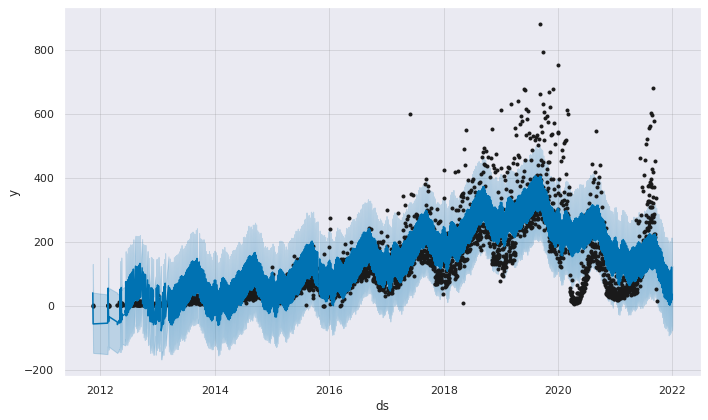

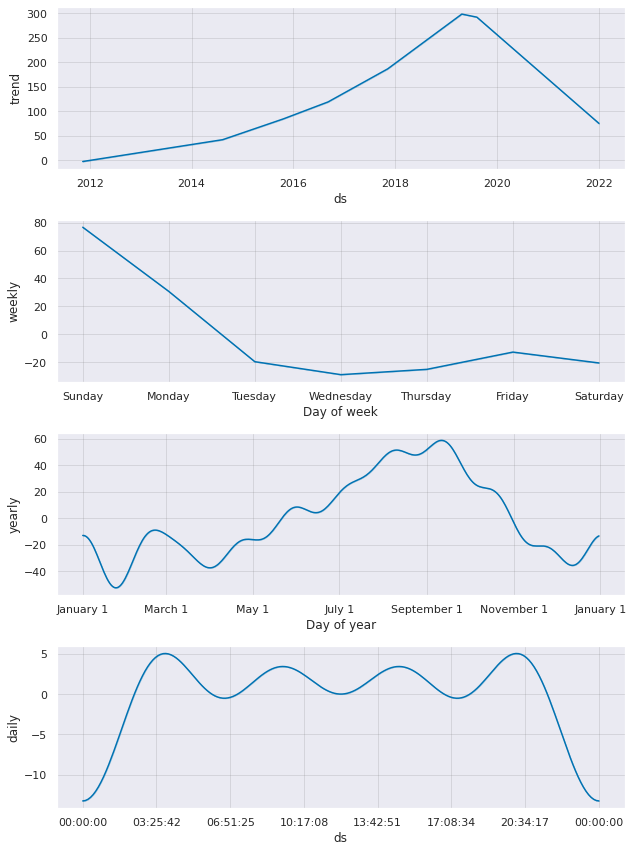

In [ ]:
fcst = create_daily_forecast(df_prophet,
                            #  cap,
                             holidays,
                             growth,
                             n_changepoints,
                             changepoint_prior_scale,
                             changepoints,
                             holidays_prior_scale,
                             interval_width,
                             mcmc_samples,
                             future_num_points,
                             daily_seasonality)

In [ ]:
def calculate_mape(y_true, y_pred):
  ''' Calculate mean absolute percentage error (MAPE)'''
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_mpe(y_true, y_pred):
  ''' Calculate mean percentage error (MPE)'''
  return np.mean((y_true - y_pred) / y_true) * 100

def calculate_mae(y_true, y_pred):
  ''' Calculate mean absolute error (MAE)'''
  return np.mean(np.abs(y_true - y_pred)) * 100

def calculate_rmse(y_true, y_pred):
  ''' Calculate root mean square error (RMSE)'''
  return np.sqrt(np.mean((y_true - y_pred)**2))

def calculate_error_metrics(y_true, y_pred):
  print(f'MAPE: {calculate_mape(y_true, y_pred):.2f} %')
  print(f'MPE:  {calculate_mpe(y_true, y_pred):.2f} %')
  print(f'MAE:  {calculate_mae(y_true, y_pred):.2f} %')
  print(f'RMSE: {calculate_rmse(y_true, y_pred):.2f} %')
  return 


In [ ]:
calculate_error_metrics(y_true = df_prophet['y'], y_pred = fcst['yhat'])

MAPE: 195.81 %
MPE:  -13.48 %
MAE:  4748.14 %
RMSE: 71.43 %


# **Modelling Time-Series Data: Long Short-Term Memory Networks (LSTM)**

We will be going through an example here.

In [ ]:
def do_lstm_model(df, 
                  ts, 
                  look_back, 
                  epochs, 
                  type_ = None, 
                  train_fraction = 0.67):
  """
   Create LSTM model
   Source: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
  """
  # Import packages
  import numpy
  import matplotlib.pyplot as plt
  from pandas import read_csv
  import math
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.metrics import mean_squared_error

  # Convert an array of values into a dataset matrix
  def create_dataset(dataset, look_back=1):
    """
    Create the dataset
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), 0]
      dataX.append(a)
      dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

  # Fix random seed for reproducibility
  numpy.random.seed(7)

  # Get dataset
  dataset = df[ts].values
  dataset = dataset.astype('float32')

  # Normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset.reshape(-1, 1))
  
  # Split into train and test sets
  train_size = int(len(dataset) * train_fraction)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
  # Reshape into X=t and Y=t+1
  look_back = look_back
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  
  # Reshape input to be [samples, time_stamps, features]
  if type_ == 'regression with time steps' or type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  else:
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
  # Create and fit the LSTM network
  batch_size = 1
  model = Sequential()
  
  if type_ == 'regression with time steps':
    model.add(LSTM(4, input_shape=(look_back, 1)))
  elif type_ == 'memory between batches':
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  elif type_ == 'stacked with memory between batches':
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  else:
    model.add(LSTM(4, input_shape=(1, look_back)))
  
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    for i in range(100):
      model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
      model.reset_states()
  else:
    model.fit(trainX, 
              trainY, 
              epochs = epochs, 
              batch_size = 1, 
              verbose = 2)
  
  # Make predictions
  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)
  else:
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
  
  # Invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  
  # Calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  
  # Shift train predictions for plotting
  trainPredictPlot = numpy.empty_like(dataset)
  trainPredictPlot[:, :] = numpy.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
  # Shift test predictions for plotting
  testPredictPlot = numpy.empty_like(dataset)
  testPredictPlot[:, :] = numpy.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  
  # Plot baseline and predictions
  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()
  plt.close()
  
  return

Epoch 1/5
2239/2239 - 4s - loss: 0.0057
Epoch 2/5
2239/2239 - 2s - loss: 0.0031
Epoch 3/5
2239/2239 - 2s - loss: 0.0031
Epoch 4/5
2239/2239 - 2s - loss: 0.0030
Epoch 5/5
2239/2239 - 3s - loss: 0.0030
Train Score: 50.55 RMSE
Test Score: 114.09 RMSE


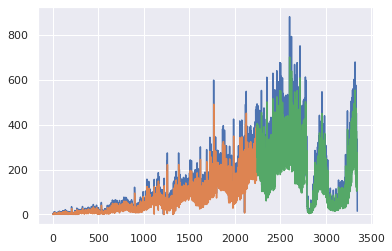

Epoch 1/5
2237/2237 - 4s - loss: 0.0046
Epoch 2/5
2237/2237 - 2s - loss: 0.0029
Epoch 3/5
2237/2237 - 3s - loss: 0.0028
Epoch 4/5
2237/2237 - 3s - loss: 0.0027
Epoch 5/5
2237/2237 - 3s - loss: 0.0026
Train Score: 44.65 RMSE
Test Score: 102.78 RMSE


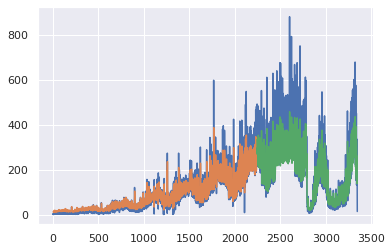

Epoch 1/5
2237/2237 - 5s - loss: 0.0039
Epoch 2/5
2237/2237 - 3s - loss: 0.0031
Epoch 3/5
2237/2237 - 3s - loss: 0.0030
Epoch 4/5
2237/2237 - 3s - loss: 0.0029
Epoch 5/5
2237/2237 - 3s - loss: 0.0028
Train Score: 45.94 RMSE
Test Score: 104.64 RMSE


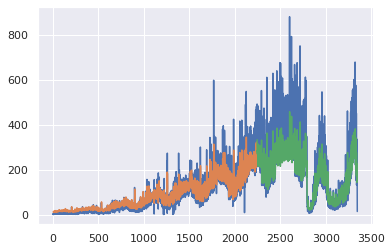

In [ ]:
# LSTM Network for Regression
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 1, 
              epochs = 5)

# LSTM for Regression Using the Window Method
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 3, 
              epochs = 5)

# LSTM for Regression with Time Steps
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 3, 
              epochs = 5, 
              type_ = 'regression with time steps')

# # LSTM with Memory Between Batches
# do_lstm_model(df = df_prophet, 
#               ts = 'y', 
#               look_back = 3, 
#               epochs = 5, 
#               type_ = 'memory between batches')

# # Stacked LSTMs with Memory Between Batches
# do_lstm_model(df = df_prophet, 
#               ts = 'y', 
#               look_back = 3, 
#               epochs = 5, 
#               type_ = 'stacked with memory between batches')